In [2]:
import xarray as xr
import numpy as np
from stompy.model.suntans import sun_driver
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
run_dir="/opt/sfb_ocean/suntans/runs/merge_005-20170610avg/"

In [5]:
model=sun_driver.SuntansModel.load(run_dir)


model.load_bc_ds()

INFO:DFlowModel:Will read cell depths, too
INFO:DFlowModel:Will read edge depths, too
INFO:UnstructuredGrid:Will flip 0 edges


In [7]:
model.bc_ds

<xarray.Dataset>
Dimensions:      (Nk: 50, Npoint: 3, Nseg: 15, Nt: 7350, Ntype2: 296, Ntype3: 0)
Dimensions without coordinates: Nk, Npoint, Nseg, Nt, Ntype2, Ntype3
Data variables:
    z            (Nk) float64 ...
    time         (Nt) datetime64[ns] ...
    cellp        (Ntype3) int32 ...
    xv           (Ntype3) float64 ...
    yv           (Ntype3) float64 ...
    uc           (Nt, Nk, Ntype3) float64 ...
    vc           (Nt, Nk, Ntype3) float64 ...
    wc           (Nt, Nk, Ntype3) float64 ...
    T            (Nt, Nk, Ntype3) float64 ...
    S            (Nt, Nk, Ntype3) float64 ...
    h            (Nt, Ntype3) float64 ...
    edgep        (Ntype2) int32 ...
    xe           (Ntype2) float64 ...
    ye           (Ntype2) float64 ...
    boundary_h   (Nt, Ntype2) float64 ...
    boundary_u   (Nt, Nk, Ntype2) float64 ...
    boundary_v   (Nt, Nk, Ntype2) float64 ...
    boundary_w   (Nt, Nk, Ntype2) float64 ...
    boundary_T   (Nt, Nk, Ntype2) float64 ...
    boundary_S   (Nt

<IPython.core.display.Javascript object>


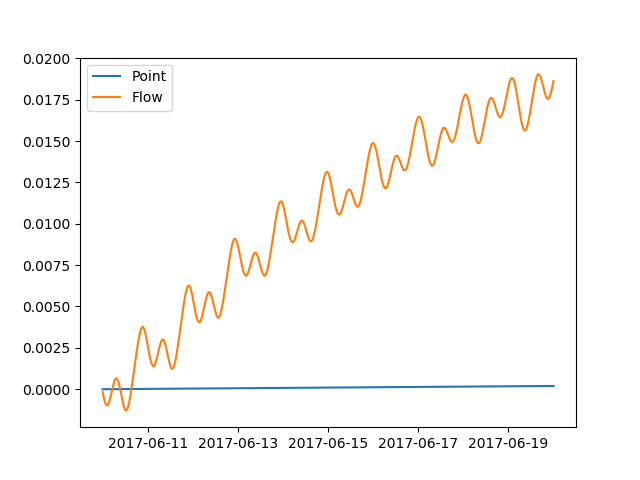

In [17]:
plt.figure()

t_sel=(model.bc_ds.time>=model.run_start) & (model.bc_ds.time<=model.run_stop)
bc_sub=model.bc_ds.isel(Nt=t_sel)

point_Q=bc_sub.point_Q.sum(dim='Npoint')
bound_Q=bc_sub.boundary_Q.sum(dim='Nseg')

seconds=(bc_sub.time.values-bc_sub.time.values[0])/np.timedelta64(1,'s')
dt=np.median(np.diff(seconds))

sum_point_Q=np.cumsum(point_Q.values)*dt
sum_bound_Q=np.cumsum(bound_Q.values)*dt

A=model.grid.cells_area().sum()

plt.plot( bc_sub.time, sum_point_Q/A,label='Point')
plt.plot( bc_sub.time, sum_bound_Q/A,label='Flow')
plt.legend()


In [19]:
map_ds=xr.open_dataset(model.map_outputs()[0])

In [25]:
# 2.5m over 10 days
Q_accum = 2.5 * A / (10*86400)
Q_accum # 110,000 m3/s
# if that were

110178.32356251046

In [36]:
bc_edges=np.nonzero( model.grid.edges['mark']==2 )[0]
L=model.grid.edges_length()[bc_edges]

bc_cells=model.grid.edge_to_cells(bc_edges).max(axis=1)
depth=map_ds.dv.isel(Nc=bc_cells)

flux_A=(L*depth).sum()
flux_A # 1.6e9
Q_accum/flux_A # 6.8e-5

<xarray.DataArray 'dv' ()>
array(6.86452e-05)

In [40]:
# so the accumulation can be easily offset with a very small flow if that
# flow is applied everywhere.
# what about only near shore?
# 100m cutoff => 0.17 m/s
# 200m cutoff => 0.06 m/s
sel=(depth<200.)
Q_accum/(L*depth)[sel].sum()

<xarray.DataArray 'dv' ()>
array(0.055647)

In [49]:
Q_accum/(L.sum()*5)

0.041856169693536276